In [56]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

np.random.seed(888)

%matplotlib inline

In [57]:
# Get current working directory
cwd = os.getcwd()
# Remove all children directories
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
# Make sure directory ends with project's name
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(rd,'stochastic-travel-demand-modelling/')
    
sys.path.append('..')

from models.singly_constrained.spatial_interaction_model import SpatialInteraction

# Create data

## Origin and destination locations

In [82]:
# Set artificial info for destination sizes
dataset = 'synthetic'
var = 'dummy'
filepath = '../data/input/synthetic'
init_year = 0
final_year = 5
cambridge_data = True # False would generate Ward locations and randomly populate cost and flow matrix

# Take subset of origins and destinations 
N = 3
M = 2

In [83]:
if not cambridge_data:
    # Import processed ward coordinates
    ward_coordinates = gpd.read_file("../data/input/misc/ward_coordinates.json")
    n_locs = ward_coordinates.shape[0]
    
    if N == 1:
        origins = [ward_coordinates[['ward_new','geometry']][0].values]
    else:
        origins = ward_coordinates[['ward_new','geometry']][0:N].values
    if M == 1: 
        destinations = [ward_coordinates[['ward_new','geometry']][0].values]
    else:
        destinations = ward_coordinates[['ward_new','geometry']][0:M].values


    # Get origin and destination locations
    origin_locs = [[x[1].centroid.x,x[1].centroid.y] for x in origins]
    destination_locs = [[x[1].centroid.x,x[1].centroid.y] for x in destinations]

    # # Get origin and destination names
    origin_names = [x[0] for x in origins]
    destination_names = [x[0] for x in destinations]
    
else:
    # Manually create coordinates
    origins = [
        {
          "type": "Feature",
          "properties": {"name":"homerton"},
          "geometry": {
            "type": "Point",
            "coordinates": [
              0.15106201171874997,
              52.175510777101074
            ]
          }
        },
        {
          "type": "Feature",
          "properties": {"name":"hughes_hall"},
          "geometry": {
            "type": "Point",
            "coordinates": [
              0.13355255126953125,
              52.19950596108069
            ]
          }
        },
        {
          "type": "Feature",
          "properties": {"name":"newnham"},
          "geometry": {
            "type": "Point",
            "coordinates": [
              0.10282516479492186,
              52.196138997125985
            ]
          }
        }
      ]

    destinations = [
        {
          "type": "Feature",
          "properties": {"name":"west_cam"},
          "geometry": {
            "type": "Point",
            "coordinates": [
              0.08050918579101562,
              52.212760902425885
            ]
          }
        },
        {
          "type": "Feature",
          "properties": {"name":"central_cam"},
          "geometry": {
            "type": "Point",
            "coordinates": [
              0.12205123901367186,
              52.20424032262008
            ]
          }
        }
    ]

    # Get origin and destination locations
    origin_locs = [[shape(x['geometry']).x,shape(x['geometry']).y] for x in origins]
    destination_locs = [[shape(x['geometry']).x,shape(x['geometry']).y] for x in destinations]

    # Get origin and destination names
    origin_names = [x['properties']['name'] for x in origins]
    destination_names = [x['properties']['name'] for x in destinations]
    
    
    if N == 1:
        origins = [origins[0]]
    else:
        origins = origins[0:(N+1)]
    if M == 1: 
        destinations = [destinations[0]]
    else:
        destinations = destinations[0:(M+1)]

## Set true parameters

In [84]:
# Set true alpha and beta
true_alpha = 0.8 #1.1
true_beta = 6.469646964696469 # 4.158415841584159 #6.470
true_delta = 0
true_kappa = 1 + true_delta*M
true_gamma = 10000
true_epsilon = 1

theta = np.array([true_alpha,true_beta,true_delta,true_gamma,true_kappa,true_epsilon])

## Create or import origin-destination data

In [100]:
create_data = True

In [101]:
if create_data:
    # Set cost matrix
    cost_matrix =  np.random.randint(1,(N+1)*(M+1), size=(N,M))#np.ones((N,M))
    c = cost_matrix/np.sum(cost_matrix)

    # Set origin supply
    origin_supply = np.random.randint(1,(N+1)*(M+1), size=(N)) #np.ones(N)
    o = origin_supply/np.sum(origin_supply)

    # Set destination demand
    destination_demand = np.random.randint(1,(N+1)*(M+1), size=(M))
    d = destination_demand/np.sum(destination_demand)

    # Set destination sizes
    initial_destination_sizes = (true_kappa + true_delta * M) * destination_demand
    xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

    # Construct flow matrix
    T = np.zeros((N,M))
    
    if N == 2 and M == 2:
        origin_supply = np.array([8,6])
        o = o/np.sum(origin_supply)

        destination_demand = np.array([8,6])
        d = destination_demand/np.sum(destination_demand)

        cost_matrix = np.array([[-1,4],[4,-1]])
        cost_matrix[0,0] = np.random.randint(1,10,1)
        cost_matrix[1,1] = np.random.randint(1,10,1)
        c = cost_matrix/np.sum(cost_matrix)
        
        initial_destination_sizes = np.array([8,6])
        
        xd = np.log(d)
    
    elif N == 3 and M == 2:
        # Set cost matrix
        cost_matrix = np.array([[1,2],[0.5,0.5],[2,1]])
        c = cost_matrix/np.sum(cost_matrix)

        # Set origin supply
        origin_supply = np.array([1,1,1])
        o = origin_supply/np.sum(origin_supply)

        # Set destination demand
        destination_demand = np.array([1.1,1])# np.array([1,2])
        d = destination_demand/np.sum(destination_demand)

        # Set destination sizes
        initial_destination_sizes = (true_kappa + true_delta * M) * destination_demand
        xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
else:
    # Import relevant data
    origin_supply = np.loadtxt(f'../data/input/synthetic/origin_supply.txt')
    destination_demand = np.loadtxt(f'../data/input/synthetic/destination_demand.txt')
    initial_destination_sizes = np.loadtxt(f'../data/input/synthetic/initial_destination_sizes.txt')
    cost_matrix = np.loadtxt(f'../data/input/synthetic/cost_matrix.txt')
    destinations = np.loadtxt(f'../data/input/synthetic/destinations.txt',dtype='str',delimiter='\n')

    # Store dimensions
    N,M = cost_matrix.shape

    # Normalise log sizes
    xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
    # Normalise normalised cost_matrix
    c = cost_matrix/np.sum(cost_matrix)
    # Normalise normalised origin_supply
    o = origin_supply/np.sum(origin_supply)
    # Normalise destination demand
    d = destination_demand/np.sum(destination_demand)

# Define parameters
theta = np.array([true_alpha, true_beta, true_delta, true_gamma, true_kappa, 1]).astype('float64')

true_beta 6.469646964696469
min cost contribution 0.15747783491130046
max cost contribution 0.6299482282618398


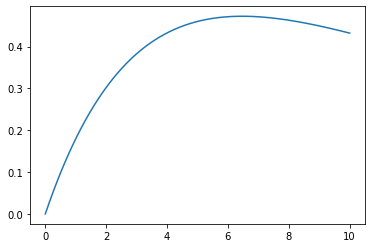

In [102]:
trials = np.linspace(0,10,10000)
y = [np.max(np.exp(-c*x))-np.min(np.exp(-c*x)) for x in trials]

plt.plot(trials,y)

true_beta = trials[np.argmax(y)]
print('true_beta',true_beta)

print('min cost contribution',np.min(np.exp(-c*true_beta)))
print('max cost contribution',np.max(np.exp(-c*true_beta)))

In [103]:
T = np.zeros((N,M))

# Construct flow matrix
si = DSIM(dataset)

value = si.infer_flows_ipf_procedure(T,
                                o,
                                d,
                                c,
                                np.exp(xd)*true_kappa,
                                np.ones(N),
                                np.ones(M),
                                N,
                                M,
                                theta,
                                10000,
                                0.000000001,
                                False)


<class 'numpy.ndarray'>
(3,)


# Print key variables

In [104]:
print('Cost matrix')
print(pd.DataFrame(cost_matrix))
print(pd.DataFrame(c))

print('Flow matrix')
print(pd.DataFrame(T))

Cost matrix
     0    1
0  1.0  2.0
1  0.5  0.5
2  2.0  1.0
          0         1
0  0.142857  0.285714
1  0.071429  0.071429
2  0.285714  0.142857
Flow matrix
          0         1
0  0.245836  0.087497
1  0.175727  0.157607
2  0.102246  0.231087


In [105]:
print('estimated destination demand')
print(np.sum(T,axis=0))
print('actual destination demand')
print(d)
print('estimated destination sizes')
print(np.sum(T,axis=0)/true_kappa)
print('actual destination sizes')
print(initial_destination_sizes/np.sum(initial_destination_sizes))

estimated destination demand
[0.52380952 0.47619048]
actual destination demand
[0.52380952 0.47619048]
estimated destination sizes
[0.52380952 0.47619048]
actual destination sizes
[0.52380952 0.47619048]


In [106]:
print('estimated origin supply')
print(np.sum(T,axis=1))
print('actual origin supply')
print(o)

estimated origin supply
[0.33333333 0.33333333 0.33333333]
actual origin supply
[0.33333333 0.33333333 0.33333333]


In [107]:
print("Minimum destination size")
print(np.min(np.exp(xd)))

print('alpha',true_alpha)
print('beta',true_beta)

Minimum destination size
0.47619047619047616
alpha 0.8
beta 6.469646964696469


# Verify equilibria number and stability

This is based on 
- [1]: page 478 of Rijk, F. J. A., & Vorst, A. C. F. (1983). On the Uniqueness and Existence of Equilibrium Points in an Urban Retail Model. Environment and Planning A: Economy and Space, 15(4), 475–482. https://doi.org/10.1068/a150475
- [2]: page 391 of Rijk, F. J. A., & Vorst, A. C. F. (1983). Equilibrium points in an urban retail model and their connection with dynamical systems. Regional Science and Urban Economics, 13(3), 383–399. https://doi.org/10.1016/0166-0462(83)90024-8

In [108]:
if M == 2 and N == 2 and (T[0,1]-T[1,0]) <= 0.000001:
    cost = true_kappa*(c[0,0]**2 + c[0,1]**2)
    a = true_kappa*(c[0,0]*c[0,1])
    p = cost/(2*a)
    p0 = np.ones((M)) * N/(2*true_kappa)
    
    if c[0,1] != c[1,0]:
        raise ValueError(f"This is not a symmetric cost matrix {c}")
    
    if 0 < true_alpha and true_alpha <= 0.5:
        # Obtained from [1]
        print('There is exactly 1 unique possible solution to this dynamical system.')
    elif true_alpha < 1 or true_alpha >= (0.5*(1+p)):
        # Obtained from [1,2]
        print('There is exactly 1 possible solution to this dynamical system.')
    elif true_alpha > 1 and true_alpha < (0.5*(1+p)): 
        # Obtained from [2]
        print('There is exactly 3 possible solutions to this dynamical system.')
    else:
        print('This is an unknown case.')
        
    if true_alpha > (0.5*(1+p)):
        print(f'P0 {p0} is unstable.')
    elif true_alpha < (0.5*(1+p)): 
        print(f'P0 {p0} is stable.')
    else:
        print('This is an unknown case.')
        
#     print(true_alpha,0.5*(1+p),p)
    
print(np.min(np.exp(xd)))
    

0.47619047619047616


In [109]:
export_data = True

In [110]:
if export_data:
    # Export cost matrix
    np.savetxt(f'../data/input/{dataset}/cost_matrix.txt',cost_matrix)

    # Export flow matrix
    np.savetxt(f'../data/input/{dataset}/od_matrix.txt',T)

    # Export origin-related data to txt
    np.savetxt(f'../data/input/{dataset}/origin_supply.txt',origin_supply)
    np.savetxt(f'../data/input/{dataset}/origin_locations.txt',origin_locs)
    np.savetxt(f'../data/input/{dataset}/origins.txt',origin_names,fmt="%s")

    # Export destination-related data to txt
    np.savetxt(f'../data/input/{dataset}/destination_demand.txt',destination_demand)
    np.savetxt(f'../data/input/{dataset}/destination_locations.txt',destination_locs)
    np.savetxt(f'../data/input/{dataset}/destinations.txt',destination_names,fmt="%s")

    # Export destination sizes to txt
    np.savetxt(f'../data/input/{dataset}/initial_destination_sizes.txt',initial_destination_sizes)
    # np.savetxt(f'../data/input/{dataset}/final_destination_sizes.txt',final_destination_sizes)

    # Export semantic meaning of destination sizes
    with open(f"../data/input/{dataset}/destination_sizes_info.txt", "w") as text_file:
        print(f"destination_sizes_data_filepath,{filepath}", file=text_file)
        print(f"destination_sizes_variable,{var}", file=text_file)
        print(f"initial_destination_sizes_year,{str(init_year)}", file=text_file)
    #     print(f"final_destination_sizes_year,{str(final_year)}", file=text_file)
        print(f"true_alpha,{str(true_alpha)}", file=text_file)
        print(f"true_beta,{str(true_beta)}", file=text_file)
        print(f"true_delta,{str(true_delta)}", file=text_file)
        print(f"true_kappa,{str(true_kappa)}", file=text_file)

In [111]:
true_alpha

0.8

In [112]:
true_beta

6.469646964696469

# Check for convexity of potential function

Hessian matrix must be semi-positive definite

In [113]:
def is_pos_semidef(M):
    return np.all(np.linalg.eigvals(M) >= 0)

def convexity_test(M):
    
    if is_pos_semidef(M):
        print('Potential function is convex.')
        return True
    else:
        print('Potential function is NOT convex.')
        return False
    
def my_convexity_test(M):
    if M.shape[0] != 2:
        raise Exception(f'This test does not work for M={M.shape[0]}')
    
    ratio = np.exp(np.sum(xd)) / (np.sum(np.exp(2*xd)))
    
    if theta[0] <= ratio:
        print('Potential function is convex.')
        return True
    else:
        print(f'ratio = {ratio}')
        print(f'alpha = {theta[0]}')
        print('Potential function is NOT convex.')
        return False


In [114]:
si = SpatialInteraction('synthetic')
si.normalise_data()

# Change alpha and/or beta
# theta[0] = 0.8
theta[2] = np.min(np.exp(xd))
theta[3] = 1 + np.min(np.exp(xd))*si.M

# Print theta
print(f'alpha = {theta[0]}, beta = {theta[1]}, delta = {theta[2]}, kappa = {theta[3]}')

# Get hessian
hessian = si.potential_hessian(xd,theta)

# Run convexity test
convexity_test(hessian)
# my_convexity_test(hessian)

alpha = 0.8, beta = 6.469646964696469, delta = 0.47619047619047616, kappa = 1.9523809523809523
Potential function is convex.


True